# Building script to download data - create zarr store

In [1]:
import xarray as xr
import pandas as pd
import ooipy
from datetime import datetime
import numpy as np
from scipy import interpolate
from OOI_hydrophone_cloud import utils
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [ ]:
# download 1 hour of data
start_time = datetime(2015,2,2)
end_time = datetime(2015,2,3)

ab = ooipy.request.hydrophone_request.get_acoustic_data_LF(start_time, end_time, node='Axial_Base')
cc = ooipy.request.hydrophone_request.get_acoustic_data_LF(start_time, end_time, node='Central_Caldera')
ec = ooipy.request.hydrophone_request.get_acoustic_data_LF(start_time, end_time, node='Eastern_Caldera')
sb = ooipy.request.hydrophone_request.get_acoustic_data_LF(start_time, end_time, node='Slope_Base')
sh = ooipy.request.hydrophone_request.get_acoustic_data_LF(start_time, end_time, node='Southern_Hydrate')

In [ ]:
ab_interp, _ = utils.interpolate_time_coord(ab, start_time, end_time)
cc_interp, _ = utils.interpolate_time_coord(cc, start_time, end_time)
ec_interp, _ = utils.interpolate_time_coord(ec, start_time, end_time)
sb_interp, _ = utils.interpolate_time_coord(sb, start_time, end_time)
sh_interp, time_grid = utils.interpolate_time_coord(sh, start_time, end_time)

## Create dataset

In [ ]:
stations = [ab.stats.station, cc.stats.station, ec.stats.station, sb.stats.station, sh.stats.station]

In [ ]:
stations

['AXBA1', 'AXCC1', 'AXEC2', 'HYSB1', 'HYS14']

In [ ]:
attrs = {
    'sampling_rate':200,
    'delta':0.005,
    'timebase' : start_time.strftime('%Y-%m-%d T%H:%M:%S.%f'),
    'npts' : len(time_grid),
    'network':'OO',
    'channel':'HDH'
    }

attrs

{'sampling_rate': 200,
 'delta': 0.005,
 'timebase': '2015-02-02 T00:00:00.000000',
 'npts': 17280000,
 'network': 'OO',
 'channel': 'HDH'}

In [ ]:
da_ab = xr.DataArray(ab_interp, dims=['time'], attrs = attrs)
da_cc = xr.DataArray(cc_interp, dims=['time'], attrs = attrs)
da_ec = xr.DataArray(ec_interp, dims=['time'], attrs = attrs)
da_sb = xr.DataArray(sb_interp, dims=['time'], attrs = attrs)
da_sh = xr.DataArray(sh_interp, dims=['time'], attrs = attrs)

In [ ]:
ds = xr.Dataset({
    'AXBA1':da_ab,
    'AXCC1':da_cc,
    'AXEC2':da_ec,
    'HYSB1':da_sb,
    'HYS14':da_sh,
})

## Build time loop

In [18]:
from datetime import datetime
from datetime import timedelta

In [19]:
time_base = datetime(2015,1,1)
chunk_length = timedelta(days=1)

In [32]:
for k in range(2800):
    starttime = time_base + (k*chunk_length)
    endtime = time_base + ((k+1)*chunk_length)

In [33]:
starttime

datetime.datetime(2022, 8, 31, 0, 0)

In [34]:
endtime

datetime.datetime(2022, 9, 1, 0, 0)

## Write to cloud

In [ ]:
ds = ds.chunk({'time':3600*200})

In [ ]:
storage_options={'account_name': 'lfhydrophone', 'account_key': 'UohL6H3jDaDLliug0g2Lg5qZZNKWdyxkq2S5KYLE0EFwLjo09auQp48PyhBRKJtYsfjXMmie/d/9+AStLFAniQ=='}
ds.to_zarr('abfs://hydrophonedata/lf_data.zarr', storage_options=storage_options)

ValueError: append_dim='time' does not match any existing dataset dimensions {}

## open zarr from cloud

In [2]:
storage_options={'account_name': 'lfhydrophone', 'account_key': 'UohL6H3jDaDLliug0g2Lg5qZZNKWdyxkq2S5KYLE0EFwLjo09auQp48PyhBRKJtYsfjXMmie/d/9+AStLFAniQ=='}
ds = xr.open_zarr('abfs://hydrophonedata/lf_data.zarr', storage_options=storage_options)

In [3]:
ds

<xarray.Dataset>
Dimensions:  (time: 3490560000)
Dimensions without coordinates: time
Data variables:
    AXBA1    (time) float32 dask.array<chunksize=(720000,), meta=np.ndarray>
    AXCC1    (time) float32 dask.array<chunksize=(720000,), meta=np.ndarray>
    AXEC2    (time) float32 dask.array<chunksize=(720000,), meta=np.ndarray>
    HYS14    (time) float32 dask.array<chunksize=(720000,), meta=np.ndarray>
    HYSB1    (time) float32 dask.array<chunksize=(720000,), meta=np.ndarray>

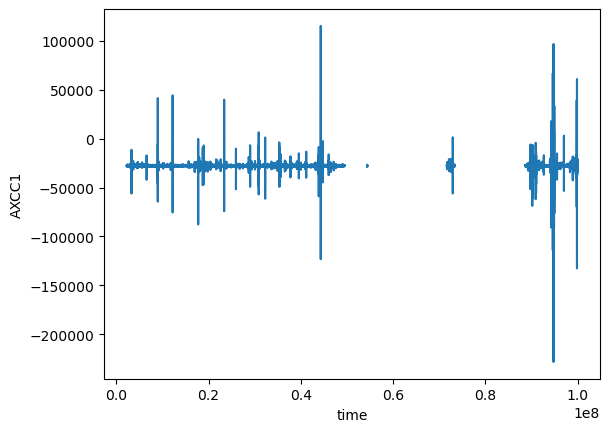

In [65]:
ds.AXCC1[1000000000:1100000000].plot()